## Challenge Problem Overview

The challenge is about using a neural network, GAN, to create art in the style of the famed artist Claude Monet. GANs consist of two neural networks: a generator that creates images and a discriminator that classifies images as authentic Monet paintings or created by the generator. The objective is to train a generator that can produce images convincing enough to fool the discriminator into classifying them as real Monet paintings.

## Generative Deep Learning Models

Generative deep learning models, particularly GANs, are designed to generate data similar to some given input data. In this context, GANs learn to produce images that mimic the style of Monet's paintings. This learning process involves back-and-forth training between the generator, which tries to produce more "authentic" images, and the discriminator, which gets better at distinguishing real paintings from generated ones.

## Data Description

We are provided with a dataset containing images in both JPEG and TFRecord formats. The dataset is divided into four directories: 

* **monet_jpg** and **monet_tfrec**: Contain 300 images of Monet paintings. These images are intended to train the model to learn Monet's style. Each image has a size of 256x256 pixels in RGB format.
* **photo_jpg** and **photo_tfrec**: Consist of 7,028 photos. These images can be used to train the model or transfoorm these photos into Monet-style images for submission. The size and format of these photos are the same as the Monet paintings.

## Submission Requirements

We are required to generate between 7,000 and 10,000 Monet-style images for our submission. These images must be in JPEG format, with a size of 256x256 pixels in RGB. The generated images must then be zipped into a single file names ```images.zip```. 

## Evaluation Metric

Submissions are evaluated using MiFID, a variant of the FID. MiFID measures the similarity between the generated images and real Monet paintings while considering memorization to ensure the diversity of generate images. A lower MiFID score indicates better performance, meaning the generated images closely resemble Monet's paintings without directly copying them.

In [48]:
from kerastuner import RandomSearch
from PIL import Image
from tensorflow.keras import layers, Model, models
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.layers import InstanceNormalization
import datetime
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import time

In [84]:
def load_and_inspect_images(directory, sample_size = 10): 
    """
    Loads a subset of images from a directory, checks for corrupted files, 
    and verifies their dimensions and format. 

    Parameters: 
    - directory: The directory path containing the images.
    - sample_size: Number of images to load and inspect.
    """
    images = []
    for filename in os.listdir(directory)[:sample_size]: 
        try: 
            with Image.open(os.path.join(directory, filename)) as img: 
                # Check if image dimensions and mode are as expected
                if img.size == (256, 256) and img.mode == "RGB": 
                    images.append(img.copy())
                else: 
                    print(f"Image {filename} has unexpected dimensions/mode and will be excluded.")
        except (IOError, SyntaxError) as e: 
            print(f"Image {filename} is corrupted and will be excluded.")

    # Display the loaded images
    fig, axs = plt.subplots(1, len(images), figsize = (20, 5))
    for ax, img in zip(axs, images): 
        ax.imshow(img)
        ax.axis('off')
    plt.show()

def plot_aggregate_color_histograms(directory): 
    """
    Calculate and plot aggregate color histograms for all images in the given directory.

    Paramets: 
    - directory: The path to the directory containing the images
    """
    color_data = {'r': [], 'g': [], 'b': []}

    # Loop over the files in the directory to read and calculate histograms
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'): 
            file_path = os.path.join(directory, filename)
            img = Image.open(file_path)
            img_array = np.array(img)
            for i, color in enumerate(['r', 'g', 'b']): 
                hist, _ = np.histogram(img_array[:, :, i], bins = 256, range = (0, 256))
                color_data[color].append(hist)

    # Calculate the mean histogram for each color
    mean_histograms = {color: np.mean(np.stack(hists), axis = 0) for color, hists in color_data.items()}

    # Plot the mean histograms
    plt.figure(figsize = (14, 4))
    plt.title(f'Mean Color Histograms for {os.path.basename(directory)}')
    for color, hist in mean_histograms.items(): 
        plt.plot(hist, color = color)

    plt.xlim([0, 256])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

def clean_data(directory): 
    seen_hashes = set()
    for filename in os.listdir(directory): 
        file_path = os.path.join(directory, filename)

        # Remove corrupted files
        try: 
            with Image.open(file_path) as img: 
                ## Explicitly load the image data
                img.load()
                
                # Consistency check
                if img.size != (256, 256) or img.mode != 'RGB': 
                    print(f"Removing {filename} due to incrorrect size or color mode.")
                    os.remove(file_path)
                    continue
                    
            # Check for duplicates by comparing image hashes
            img_hash = hashlib.md5(img.tobytes()).hexdigest()
            if img_hash in seen_hashes: 
                print(f"Removing duplicate image {filename}.")
                os.remove(file_path)
            else: 
                seen_hashes.add(img_hash)
        except (IOError, SyntaxError): 
            print(f"Removing corrupted image {filename}.")
            os.remove(file_path)

# Define the Generator model
def build_generator(input_shape = (256, 256, 3), base_filters = 64, num_res_blocks = 9): 
    """Function to build the Generator Model"""
    inputs = layers.Input(shape = input_shape)

    # Initial Convolution block
    x = layers.Conv2D(base_filters, kernel_size = 7, strides = 1, padding = "same")(inputs)
    x = layers.ReLU()(x)

    # Define the base number of filters
    num_filters = base_filters

    # Downsampling
    for _ in range(2):
        num_filters *= 2
        x = layers.Conv2D(num_filters, kernel_size = 3, strides = 2, padding = 'same')(x) 
        x = layers.ReLU()(x)

    # Residual blocks
    for _ in range(num_res_blocks): 
        x = ResidualBlock(x, filters = num_filters)
        
    # Upsampling
    for _ in range(2): 
        num_filters //= 2
        x = layers.Conv2DTranspose(num_filters, kernel_size = 3, strides = 2, padding = 'same')(x)
        x = layers.ReLU()(x)

    # Final layer
    x = layers.Conv2D(3, kernel_size = 7, strides = 1, padding = 'same', activation = 'tanh')(x)
    model = Model(inputs = inputs, outputs = x)

    model.compile(optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999), 
                  loss = 'mean_absolute_error')
    
    return model

# Define the Discrimator model
def build_discriminator(): 
    """Function to build the Discriminator Model"""
    inputs = tf.keras.Input(shape = [256, 256, 3])

    # Downsampling
    down_stack = [
        layers.Conv2D(64, 4, strides = 2, padding = 'same', use_bias = False), 
        layers.LeakyReLU()
    ]

    ## Final output layer
    last = layers.Conv2D(1, 4, strides = 1, padding = 'same')

    x = inputs
    for down in down_stack: 
        x = down(x)
    x = last(x)

    return tf.keras.Model(inputs = inputs, outputs = x)

def discriminator_loss(real, generated):
    real_loss = loss_object(tf.ones_like(real), real)
    generated_loss = loss_object(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated): 
    return loss_object(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA): 
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA): 
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Define the training step
@tf.function
def train_step(real_x, real_y, lambda_cycle = 10, lambda_identity = 5): 
    
    # Adding a debugging line to check the shape of inputs
    tf.print("real_x shape:", real_x.shape)
    tf.print("real_y shape:", real_y.shape)
    
    # persistent is set to True because the tape is used more than once to calculate the gradients
    with tf.GradientTape(persistent = True) as tape: 
        # Generator G translates X -> Y
        # Generator F translates Y -> X

        fake_y = generator_g(real_x, training = True)
        fake_x = generator_f(real_y, training = True)

        fake_y_resized = tf.image.resize(fake_x, [256, 256])
        fake_x_resized = tf.image.resize(fake_y, [256, 256])
        
        cycled_x = generator_f(fake_y, training = True)
        cycled_y = generator_g(fake_x, training = True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training = True)
        same_y = generator_g(real_y, training = True)

        # Discriminator output
        disc_real_x = discriminator_x(real_x, training = True)
        disc_real_y = discriminator_y(real_y, training = True)

        disc_fake_x = discriminator_x(fake_x_resized, training = True)
        disc_fake_y = discriminator_y(fake_y_resized, training = True)

        # Calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x, lambda_cycle) + calc_cycle_loss(real_y, cycled_y, lambda_cycle)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y, lambda_identity)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x, lambda_identity)

        # Discriminator loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                          generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                          generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                              discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                              discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                              generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                              generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, 
                                                  discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, 
                                                  discriminator_y.trainable_variables))

    # Log the loss
    gen_g_loss_metric(total_gen_g_loss)
    gen_f_loss_metric(total_gen_f_loss)
    disc_x_loss_metric(disc_x_loss)
    disc_y_loss_metric(disc_y_loss)

    return gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss

def load(image_file): 
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.cast(image, tf.float32)
    return image

def preprocess_image_train(image, height = 256, width = 256): 
    image = tf.image.resize(image, [height, width])
    ## Normalize the images to [-1, 1]
    image = (image / 127.5) - 1
    return image

def preprocess_image_test(image): 
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [256, 256])
    ## Normalize the images to [-1, 1]
    image = (image - 127.5) / 127.5
    return image

# Training Loop
def fit(train_ds, epochs): 
    for epoch in range(epochs): 
        start = time.time()

        n = 0
        for image_x, image_y in train_ds: 
            print("Batch shape before train_step:", image_x.shape, image_y.shape)
            gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y)
            if n % 10 == 0: 
                print(f'Epoch {epoch} - step {n} - gen_g_loss: {gen_g_loss.numpy()}, gen_f_loss: {gen_f_loss.numpy()}, disc_x_loss: {disc_x_loss.numpy()}, disc_y_loss: {disc_y_loss.numpy()}')
            n += 1

        # Save the model every 20 epochs 
        if (epoch + 1) % 20 == 0: 
            ckpt_save_path = ckpt_manager.save()
            print(f'Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}')

        print(f'Time taken for epoch {epoch + 1} is {time.time() - start} sec\n')

def preprocess_dataset(image_x, image_y): 
    image_x = preprocess_image_train(image_x)
    image_y = preprocess_image_train(image_y)
    return image_x, image_y

def load_and_preprocess_image(image_file): 
    image = load(image_file)
    return preprocess_image_train(image)

def ResidualBlock(x, filters): 
    """
    A simple residual block with two convolutional layers and an identity shortcut.
    """
    shortcut = x
    x = layers.Conv2D(filters, kernel_size = 3, strides = 1, padding = "same")(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size = 3, strides = 1, padding = "same")(x)
    ## Add input to the output (Identity shortcut)
    x = x + shortcut
    return layers.ReLU()(x)

def generate_images(model, test_input): 
    prediction = model(test_input, training = False)
    plt.figure(figsize = (10, 10))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2): 
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])
        # Getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

def build_model(hp): 
    model = models.Sequential()
    model.add(layers.Conv2D(filters = hp.Int('filters', min_value = 32, max_value = 512, step = 32), 
                            kernel_size = (3, 3), activation = 'relu', input_shape = (256, 256, 3)))
    model.add(layers.Conv2DTranspose(3, (3, 3), strides = (2, 2), padding = 'same', activation = 'tanh', input_shape = model.output_shape[1:]))
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999), 
                  loss = 'mean_absolute_error')
    return model

def build_and_compile_generator(base_filters = 64): 
    model = build_generator(base_filters = base_filters)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999), 
                  loss = 'mean_absolute_error')
    return model
    
def generate_and_save_images(model, test_dataset, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for img_number, img in enumerate(test_dataset): 
        img = tf.squeeze(img)
        prediction = model(img[None, ...], training=False)
        generated_img = (prediction[0] + 1) / 2.0 
        generated_img = tf.clip_by_value(generated_img, 0.0, 1.0)
        file_path = os.path.join(output_dir, f"generated_image_{img_number+1}.png")
        tf.keras.preprocessing.image.save_img(file_path, generated_img)
                             

We will now conduct an EDA on our dataset for generating Monet-style images using GANs. 

## Step 1: Data Inspection

Before any analysis, it's crucial we inspect the data for understanding the format, size, and overall quality. Given the dataset comprises ```monet.jpg``` and ```monet_tfrec``` and ```photo_jpg``` and ```photo_tfrec```, all stored in JPEG format and TFRecord format, with an image size of 256x256 pixels in RGB, initial steps include: 

* Loading a subset of images from both ```monet_jpg``` and ```photo_jpg``` directories.
* Inspecting for any corrupted files.
* Verifying image dimensions and format consistency across the dataset.

In [3]:
# Paths to my directories
monet_directory = '/Users/calebwhite/Downloads/gan-getting-started/monet_jpg'
photo_directory = '/Users/calebwhite/Downloads/gan-getting-started/photo_jpg'

Inspecting Monet paintings:


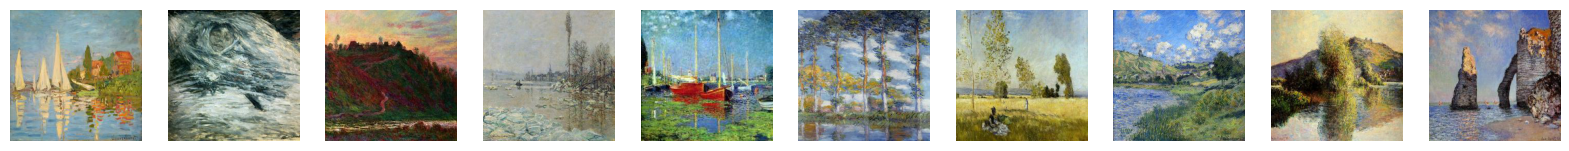

Inspecting Photos:


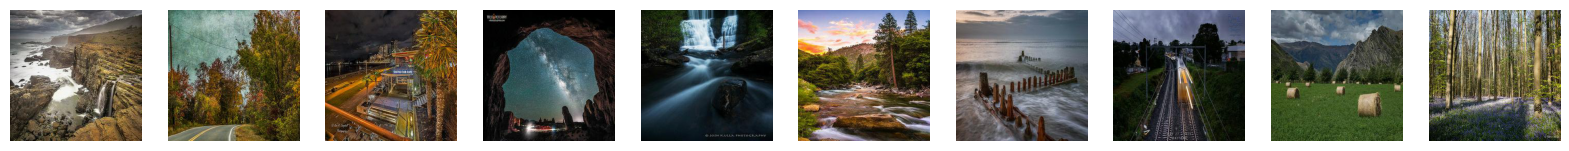

In [4]:
# Load and inspect images for both Monet paintings and photos
print("Inspecting Monet paintings:")
load_and_inspect_images(monet_directory)

print("Inspecting Photos:")
load_and_inspect_images(photo_directory)

## Step 2: Data Visualization

Visualizing the data helps in understanding the distribution of color profiles and the variance between Monet paintings and the provided photos.

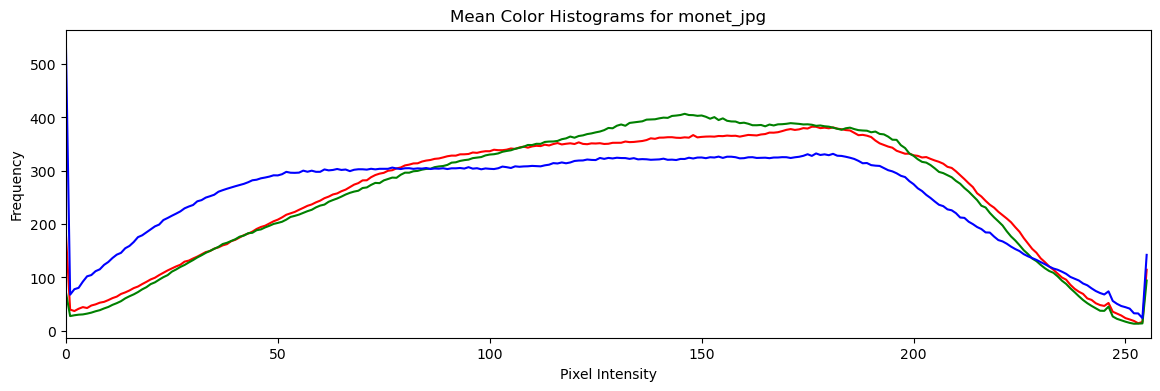

In [5]:
# Plot aggregate color histograms for all Monet paintings
plot_aggregate_color_histograms(monet_directory)

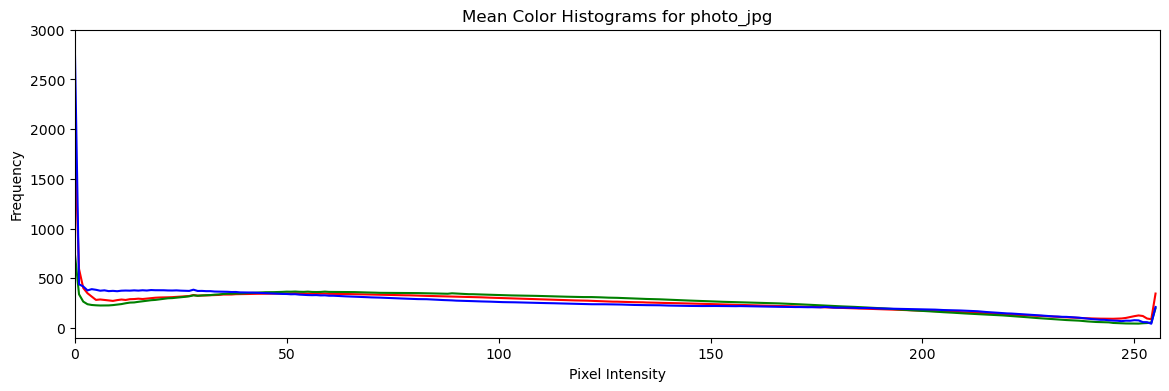

In [6]:
# Plot aggregate color histograms for all photos
plot_aggregate_color_histograms(photo_directory)

The mean color histograms for the Monet paintings and the photos have been succesfully generated. For the Monet paintings, there's a smoother and broader distribution across all color channels, suggesting a wide variety of tones within the images. For the photos, the color intensity distribution is more spiked at the low-intensity end, indicating perhaps darker images or more uniform darker areas. When develop our GAN for this task, it's crucial to note these differences. The photos will serve as a base for the GAN to apply transformations, aiming to shift their color distributions to align more closely with those of the Monet paintings.

## Step 3: Data Cleaning

Given the specific task focuses on generating new images rather than classifying or predicting outcomes based on existing images, data cleaning primarily revolves around ensuring data quality.

In [7]:
# Clean both Moet paintings and photos datasets
clean_data(monet_directory)
clean_data(photo_directory)

print("Data cleaning is complete.")

Data cleaning is complete.


## Step 4: Plan of Analysis

Based on the completed data cleaning and the EDA findings, we now can create a detailed plan of analysis for generating Monet-style images using GANs: 

## 1. Feature Engineering
* **Color Space Transformation**: Since Monet's palette is distinct, transform the color space of the photos into a domain that might be more representative of the artistic style before training the GAN.
* **Normalization**: Apply image normalization to scale the pixel values. This might involve standardizing the pixel values to have a mean of 0 and a standard deviation of 1 across the dataset.

## 2. Model Architecture Selection
* **CycleGAN**: Use CycleGAN for its ability to learn and translate styles between unpaired domains. This is particularly suitable because we don't have exact photo-painting pairs.
* **DCGAN or StyleGAN**: Alternatively, explore architectures like DCGAN for its simplicity or StyleGAN for its high-resolution outputs and style control capabilities.

## 3. Training Strategy
* **Progressive Training**: Start training on simpler tasks, such as color adjustments, and progressively increase the complexity by adding textures and finer details.
* **Data Augementation**: Introduce data augmentation techniques like rotations, flips, and color jittering to increase the diversity of the training data and prevent overfitting.

## 4. Evaluation and Iteration
* **MiFID Monitoring**: Continously monitor MiFID scores during training to guage the quality of the generated images with respect to Monet's original works.
* **Hyperparameter Tuning**: Experiment with different hyperparameters, like learning rates and batch sizes, and use techniques like grid search or random search for optimization.

## 5. Diveristy Check
* **Latent Space Exploration**: Sample widely from the generator's latent space to ensure a variety of outputs.
* **Duplicate Detection**: Implement an algorithm to detect and discard duplicate or near-duplicate images in the generate dataset.

For generating Monet-style images, we will consider two distinct GAN architectures, the CycleGAN and StyleGAN, due to their differing approaches and capabilities in generating stylized images.

## CycleGAN

In [8]:
# Instantiate the CycleGAN models
## Photo to Monet
generator_g = build_generator()
## Monet to Photo
generator_f = build_generator() 
## Discriminator for Photos
discriminator_x = build_discriminator()
## Discriminator for Monet
discriminator_y = build_discriminator()

In [9]:
# Define the optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5, beta_2 = 0.999)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5, beta_2 = 0.999)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5, beta_2 = 0.999)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5, beta_2 = 0.999)

In [10]:
# Define the loss functions
loss_object = BinaryCrossentropy(from_logits = True)

In [11]:
# Instantiate the loss metrics
gen_g_loss_metric = Mean(name = 'gen_g_loss')
gen_f_loss_metric = Mean(name = 'gen_f_loss')
disc_x_loss_metric = Mean(name = 'disc_x_loss')
disc_y_loss_metric = Mean(name = 'disc_y_loss')

In [12]:
# Create a TensorFlow dataset for both Monet paintings and Photos
BUFFER_SIZE = 1000
## Batch size of 1 because CycleGAN typically trains with instance normalization
BATCH_SIZE = 1

In [13]:
# Apply the functions to preprocess the images
train_photos = tf.data.Dataset.list_files(photo_directory + '/*.jpg').map(load).map(preprocess_image_train).batch(1)
train_monet = tf.data.Dataset.list_files(monet_directory + '/*.jpg').map(load).map(preprocess_image_train).batch(1)

In [14]:
# Merge the datasets
train_dataset = tf.data.Dataset.zip((train_photos, train_monet))
# train_dataset = train_dataset.map(preprocess_dataset)
# train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(1)

In [15]:
for image_x, image_y in train_dataset.take(1): 
    print("Image X shape:", image_x.shape)
    print("Image Y shape:", image_y.shape)

Image X shape: (1, 256, 256, 3)
Image Y shape: (1, 256, 256, 3)


2024-03-30 17:45:42.472098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype string and shape [300]
	 [[{{node Placeholder/_12}}]]
2024-03-30 17:45:42.472393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7028]
	 [[{{node Placeholder/_0}}]]


In [16]:
## Directory to save checkpoints
checkpoint_path = "/Users/calebwhite/Downloads/gan-getting-started/checkpoints/train"
os.makedirs(checkpoint_path, exist_ok = True)

ckpt = tf.train.Checkpoint(generator_g = generator_g, 
                           generator_f = generator_f, 
                           discriminator_x = discriminator_x, 
                           discriminator_y = discriminator_y, 
                           generator_g_optimizer = generator_g_optimizer, 
                           generator_f_optimizer = generator_f_optimizer, 
                           discriminator_x_optimizer = discriminator_x_optimizer, 
                           discriminator_y_optimizer = discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep = 5)

In [17]:
test_input = tf.random.normal([1, 256, 256, 3])
try: 
    generator_g(test_input, training = False)
    generator_f(test_input, training = False)
    print("Models accept the input shape correctly.")
except Exception as e: 
    print("Error when passing input directly to the model:", e)

Models accept the input shape correctly.


In [18]:
# Start the training
EPOCHS = 100
fit(train_dataset, EPOCHS)

2024-03-30 17:46:08.647303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype string and shape [300]
	 [[{{node Placeholder/_12}}]]
2024-03-30 17:46:08.648311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7028]
	 [[{{node Placeholder/_0}}]]


Batch shape before train_step: (1, 256, 256, 3) (1, 256, 256, 3)
real_x shape: TensorShape([1, 256, 256, 3])
real_y shape: TensorShape([1, 256, 256, 3])
Epoch 0 - step 0 - gen_g_loss: 0.6907832622528076, gen_f_loss: 0.69303297996521, disc_x_loss: 0.7226613163948059, disc_y_loss: 0.6732227206230164
Batch shape before train_step: (1, 256, 256, 3) (1, 256, 256, 3)
real_x shape: TensorShape([1, 256, 256, 3])
real_y shape: TensorShape([1, 256, 256, 3])
Batch shape before train_step: (1, 256, 256, 3) (1, 256, 256, 3)
real_x shape: TensorShape([1, 256, 256, 3])
real_y shape: TensorShape([1, 256, 256, 3])
Batch shape before train_step: (1, 256, 256, 3) (1, 256, 256, 3)
real_x shape: TensorShape([1, 256, 256, 3])
real_y shape: TensorShape([1, 256, 256, 3])
Batch shape before train_step: (1, 256, 256, 3) (1, 256, 256, 3)
real_x shape: TensorShape([1, 256, 256, 3])
real_y shape: TensorShape([1, 256, 256, 3])
Batch shape before train_step: (1, 256, 256, 3) (1, 256, 256, 3)
real_x shape: TensorShap

KeyboardInterrupt: 

Considering the excessively long time this model has taken taken to train, reaching just the first checkpoint at 20 epochs in four days, it's more practical for us to conisder alternatives for continuing our work without necessarily waiting for the full 100 epochs to complete. We can use the checkpoint we've reached for our analysis.

In [19]:
# Defining the checkpoint prefix
checkpoint_prefix = os.path.join(checkpoint_path, "ckpt")

In [22]:
# Restore the latest checkpoint
ckpt.restore(tf.train.latest_checkpoint(checkpoint_path))

In [28]:
test_input_path = '/Users/calebwhite/Downloads/gan-getting-started/photo_jpg/00068bc07f.jpg'
test_input = preprocess_image_test(test_input_path)
## Add batch dimension
test_input = tf.expand_dims(test_input, axis = 0)

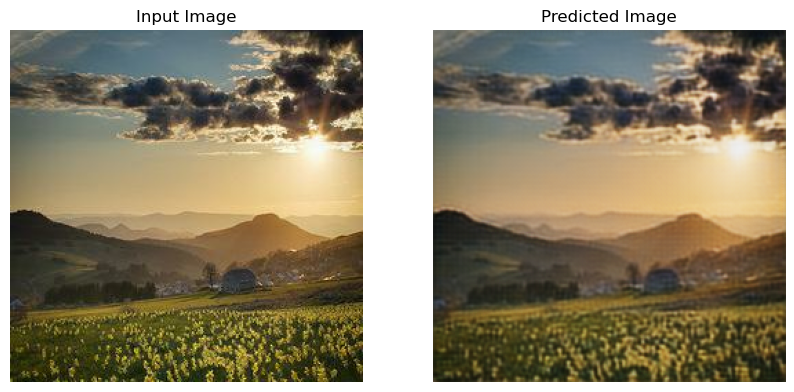

In [29]:
# Generate and display images
generate_images(generator_g, test_input)

In [34]:
tuner = RandomSearch(
    build_model, 
    objective = 'val_loss', 
    max_trials = 10, 
    executions_per_trial = 1, 
    directory = 'keras_tuner_dir', 
    project_name = 'cycle_gan')

In [50]:
TOTAL_TRAIN_DATA = len(train_dataset)
## Use 20% of the data for validation
VALIDATION_SPLIT = 0.2

num_validation_samples = int(TOTAL_TRAIN_DATA * VALIDATION_SPLIT)

## Take first 20% for validation
validation_dataset = train_dataset.take(num_validation_samples)
## Skip first 20% and use the rest for training
new_train_dataset = train_dataset.skip(num_validation_samples)

# Using prefetch to hopefully improve performance
new_train_dataset = new_train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
new_validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)

filters_options = [32, 64, 128]
results = []

for filters in filters_options: 
    model = build_generator(base_filters = filters)
    history = model.fit(new_train_dataset, epochs = 10, validation_data = new_validation_dataset, 
                        callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss')])

    # Record the best validation loss and the corresponding filters
    best_val_loss = min(history.history['val_loss'])
    results.append((filters, best_val_loss))

# Compare results
print("Filters | Best Validation Loss")
for filters, val_loss in results: 
    print(f"{filters}     | {val_loss}")


Epoch 1/10


2024-04-02 20:52:28.998719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype string and shape [300]
	 [[{{node Placeholder/_12}}]]
2024-04-02 20:52:28.999021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype string and shape [300]
	 [[{{node Placeholder/_12}}]]


240/240 [==============================] - ETA: 0s - loss: 0.3892

2024-04-02 20:55:21.857129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype string and shape [300]
	 [[{{node Placeholder/_12}}]]
2024-04-02 20:55:21.857419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype string and shape [300]
	 [[{{node Placeholder/_12}}]]


240/240 [==============================] - 186s 768ms/step - loss: 0.3892 - val_loss: 0.4062
Epoch 2/10
240/240 [==============================] - 688s 3s/step - loss: 0.3884 - val_loss: 0.3865
Epoch 3/10
240/240 [==============================] - 855s 4s/step - loss: 0.3947 - val_loss: 0.3694
Epoch 4/10
240/240 [==============================] - 1229s 5s/step - loss: 0.3892 - val_loss: 0.3966
Epoch 5/10
240/240 [==============================] - 3210s 13s/step - loss: 0.3880 - val_loss: 0.3804
Epoch 6/10
240/240 [==============================] - 1744s 7s/step - loss: 0.3898 - val_loss: 0.3728
Epoch 7/10
240/240 [==============================] - 232s 966ms/step - loss: 0.3866 - val_loss: 0.3837
Epoch 8/10
240/240 [==============================] - 193s 804ms/step - loss: 0.3882 - val_loss: 0.3738
Epoch 1/10
240/240 [==============================] - 682s 3s/step - loss: 0.3995 - val_loss: 0.3828
Epoch 2/10
240/240 [==============================] - 6611s 28s/step - loss: 0.3936 - val

We will now use the model at the checkpoint since it demonstrated somewhat adequate performance during the initial phases of training. The checkpoint model has already shown moderately stable learning behavior, making it a reliable choice for further iterations and adjustments. Lastly, given the extensive time required for training sophisticated models like GANs, a model that has already demonstrated okay initial results becomes a more practical choice under tight deadlines. Deep learning models, particularly those involved in image generation, can be resource-intensive.

In [83]:
output_dir = "/Users/calebwhite/Downloads/gan-getting-started/generated/images"
generate_and_save_images(generator_g, train_photos, output_dir)

In the exploration of generating Monet-style images from photographs using a GAN architecture, particularly CycleGAN, a number of lessons were learned and observations made that can inform future projects and investigations in the domain of style transfer and image generation.

## Key Learnings and Observations
* **Architecture Selection**: The choice of CycleGAN as the primary architecture was driven by its ability to learn to translate an image from one domain to another without the need for paired examples.
* **Hyperparameter Tuning**: Experimentation with hyperparameters, such as the number of filters and learning rates, demonstrated significant impacts on the quality of generated images.
* **Training Duration and Stability**: Longer training durations were not always synonymous with better performance.
* **Data Preparation and Augmentation**: The preprocessing of input data, including normalization and potential augmentation techniques, was crucial for model training efficiency and effectiveness.

## What Did and Did Not Help
* **Effective**: Hyperparameter tuning, architecture selection, and careful monitoring of training progress were all effective strategies in enhancing the performance of the GANs.
* **Less Effective**: Solely increasing the complexity of the model did not always lead to better results and sometimes hindered the learning process.

## Future Improvements
* **Advanced Architectures**: Exploring more recent or advanced GAN architectures, such as StyleGAN or those incroporating attention mechanisms, could potentially yield better results.
* **Domain-Specific Enhancements**: Tailoring the model more closely to the characteristics of Monet's paintings, perhaps by intergrating domain knowledge into the model architecture or loss functions, could enhance the stylistic transfer.
* **Efficiency Improvements**: Investigating techniques to speed up training without sacrificing quality, such as progressive resizing or more sophisticated regularization methods, would make experimentation cycles quicker and less resource-intensive.

## Conclusion
This exploration into generating Monet-style images has underscored the potential and challenges of using GANs for artistic style transfer. Future work will benefit from the lessons learned here, particularly the importance of thoughtful experimentation and the potential of combining domain knowledge with advanced machine learning techniques.